In [1]:
import urllib
import torch

from PIL import Image
from depth import getDepthHead
from segmentation import getSegmentationHead, getSegmentationModel
from mmseg.apis import inference_segmentor

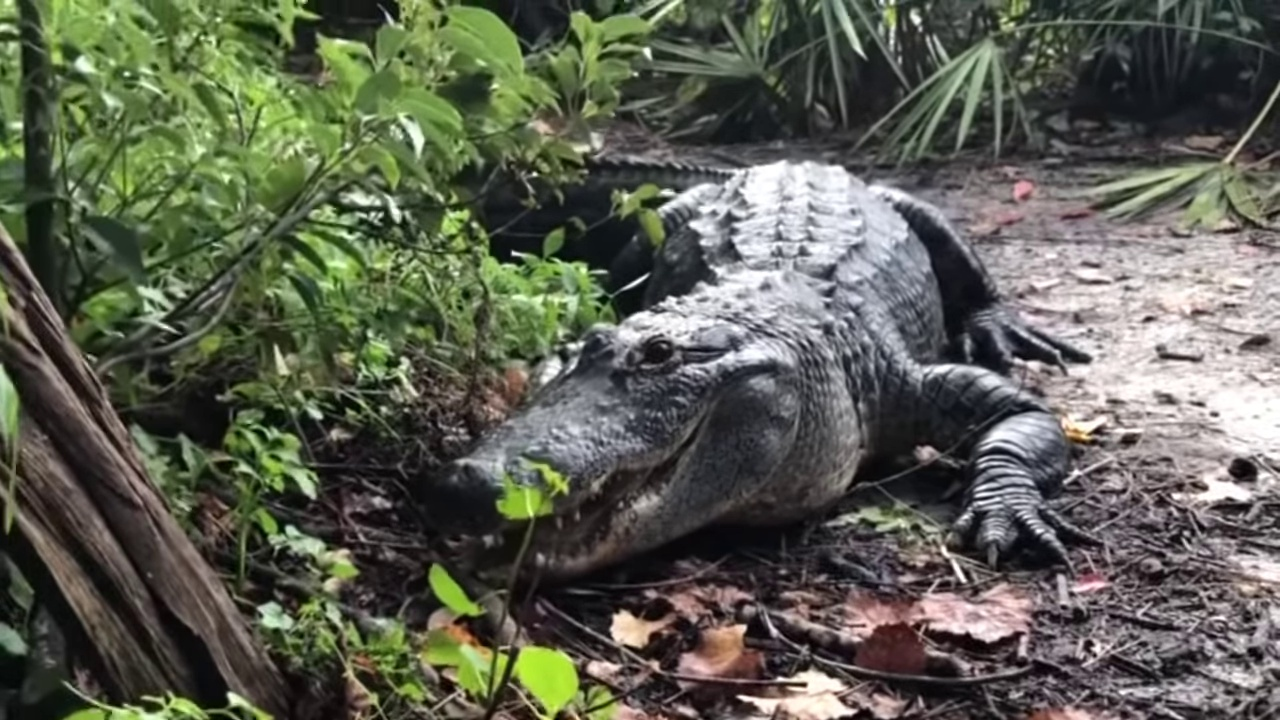

In [2]:
test_image = Image.open(r"S:/CS7643Project/audiosetdl/dataset/image/3-1.#alligators, crocodiles hissing#.train.Alligators Blackwater & Thrasher!  VLOGMAS Day 15.jpg")
display(test_image)

Using cache found in C:\Users\mjh01/.cache\torch\hub\facebookresearch_dinov2_main


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_nyu_dpt_head.pth


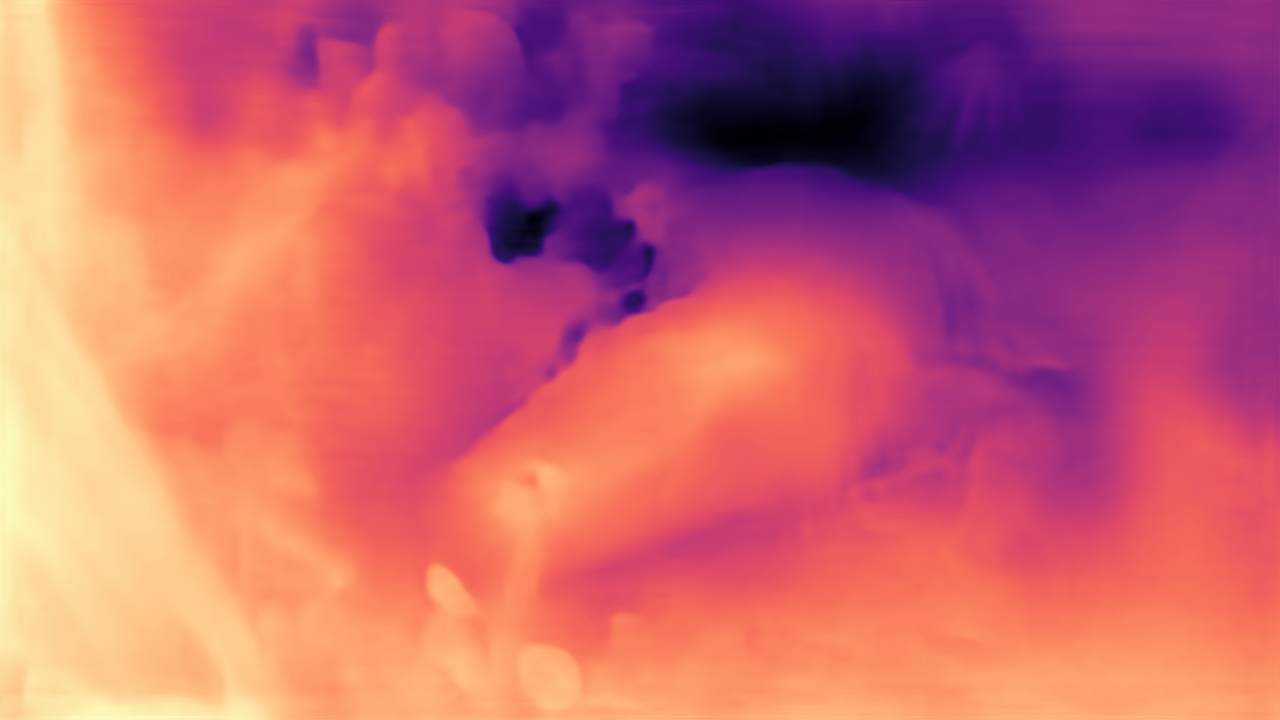

In [6]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = test_image.resize((scale_factor * test_image.width, scale_factor * test_image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

model = getDepthHead().cuda()

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

In [6]:
import numpy as np

import model.dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}

HEAD_DATASET = "voc2012"

def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

seg_model = getSegmentationModel()

array = np.array(test_image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(seg_model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

d:\CS7643\project\ImageToAudio\model\layer\../..\model\dinov2\eval\segmentation_m2f\models\losses\cross_entropy_loss.py:222: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
d:\Program_Files\anaconda3\envs\imagetoaudio4\lib\site-packages\mmcv\ops\multi_scale_deform_attn.py:216: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth" to C:\Users\mjh01/.cache\torch\hub\checkpoints\dinov2_vitg14_ade20k_m2f.pth


  0%|          | 0.00/10.8G [00:00<?, ?B/s]

d:\Program_Files\anaconda3\envs\imagetoaudio4\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\CS7643\project\ImageToAudio\model\layer\../..\model\dinov2\eval\segmentation_m2f\models\utils\positional_encoding.py:77: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_feats)


IndexError: index 127 is out of bounds for axis 0 with size 21